In [105]:
from utils import *

In [106]:
check_tensorflow_gpu()

Tensorflow built with CUDA? True
Tensorflow version: 2.10.0
# GPU available: 1
CUDA: 64_112 | cuDNN: 64_8
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [107]:
logperm, perm, poro, timesteps, bhp, pressure, saturation, well_locs, well_locs_mask = load_data()

Log-Perm: (32, 32)
Permeability: (32, 32, 3) | Porosity: (32, 32)
Pressure: (100, 32, 32, 60) | Saturation: (100, 32, 32, 60)
Timesteps: (60, 1) | BHP: (100, 60)
Well Locations: (100, 2) | Well Locations MASK: (100, 32, 32)


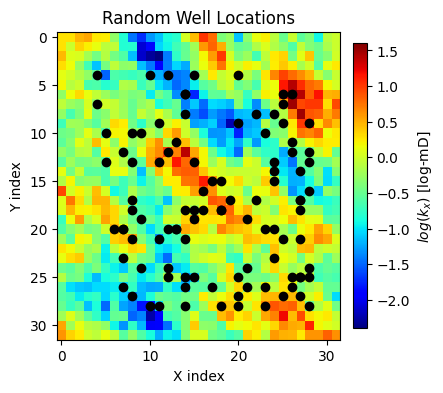

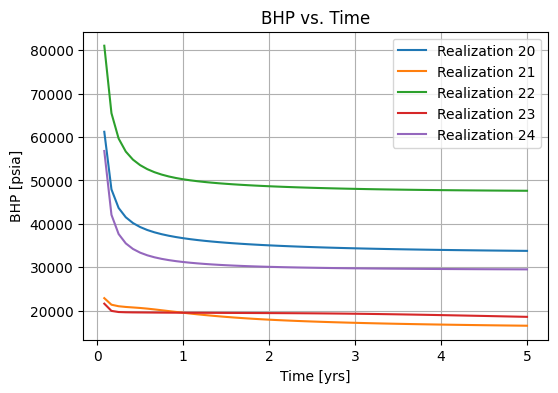

In [108]:
plot_well_locs(well_locs, logperm)
plot_bhps(bhp, timesteps, range(20,25))

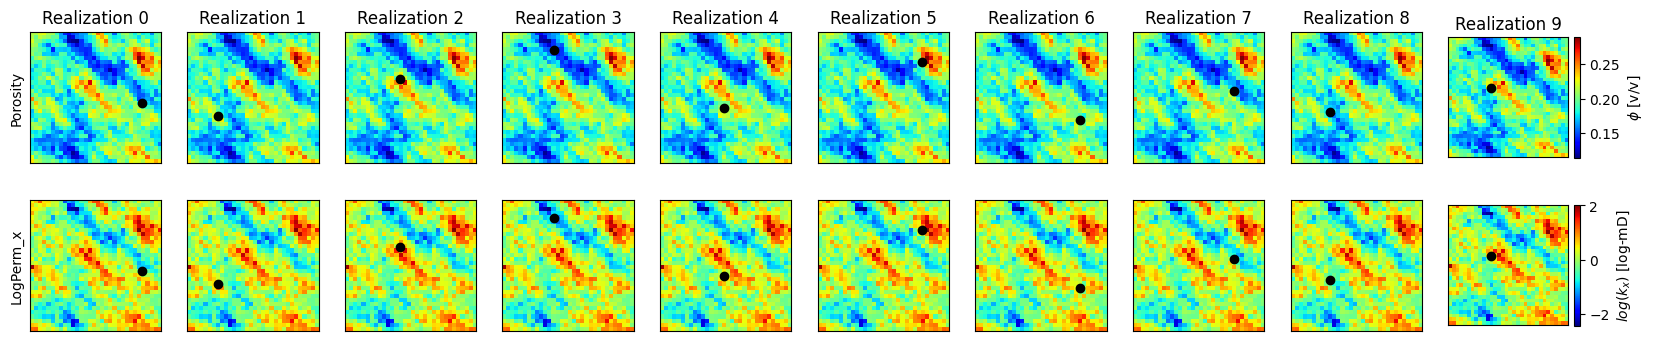

In [109]:
plot_static(poro, perm, well_locs, 10, figsize=(20,4))

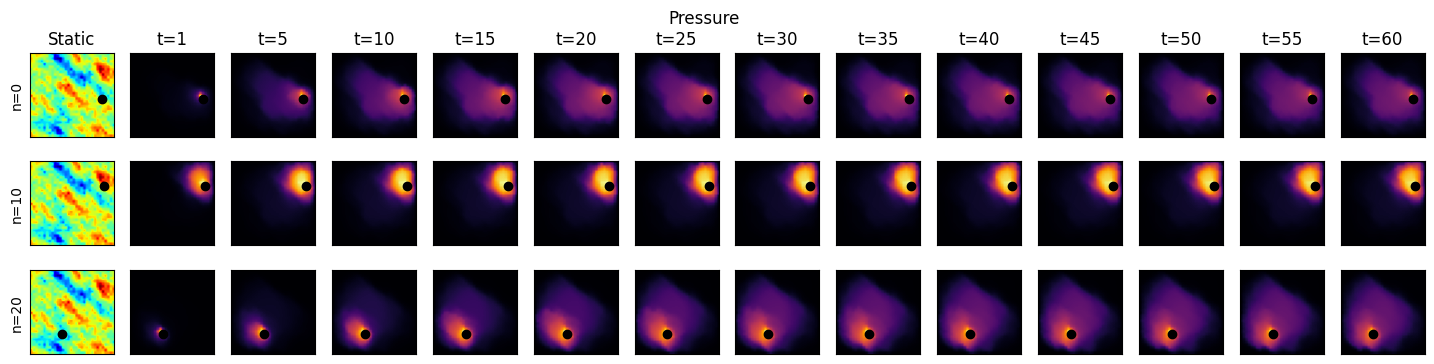

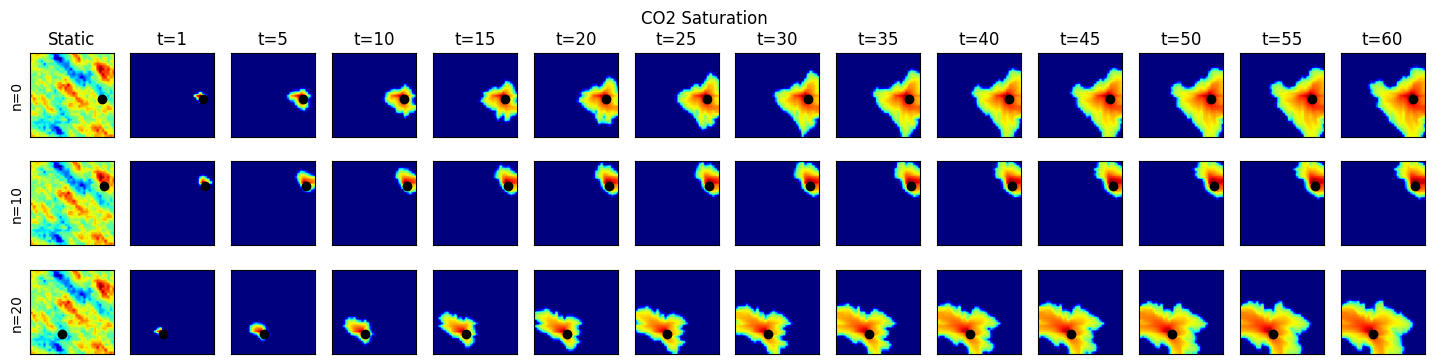

In [110]:
plot_dynamic(pressure, logperm, well_locs, nrows=3, multiplier=10, cmap='inferno', dtitle='Pressure')
plot_dynamic(saturation, logperm, well_locs, nrows=3, multiplier=10, cmap='jet', dtitle='CO2 Saturation')

***
# END

In [ ]:
inj_locs = loadmat('simulations/inj_locations.mat')['inj_locations']
mon_locs = loadmat('simulations/mon_locations.mat')['mon_locations']


In [ ]:
plt.figure(figsize=(20,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(loadmat('simulations/modrock.mat')['modrock'][i][0]['poro'][0][0].reshape(5,32,32)[0], cmap='jet')
    plt.scatter(inj_locs[i][0][0][0], inj_locs[i][0][0][1], c='k', marker='d', s=30)

In [ ]:
import pyvista as pv

In [ ]:
k = 0
fig, axs = plt.subplots(2, 5, figsize=(20,6))
for i in range(2):
    for j in range(5):
        axs[i,j].imshow(np.rot90(loadmat('simulations/modrock.mat')['modrock'][k][0]['poro'][0][0].reshape(5,32,32)[0], 3), cmap='jet')
        axs[i,j].scatter(inj_locs[k][0][0][0], inj_locs[k][0][0][1], color='k', s=50, marker='d')
        axs[i,j].set(xticks=[], yticks=[], title='Realization {}'.format(k+1))
        k += 1
plt.show()

In [ ]:
temp = np.log10(1.01325E15*np.flip(loadmat('simulations/modrock.mat')['modrock'][-1][0]['perm'][0][0][:,0].reshape(5,32,32).T))
p = pv.Plotter()
p.add_mesh(temp, cmap='jet', show_edges=True, scalar_bar_args={'title':'Log-Permeability [mD]'})
p.show(jupyter_backend='static', window_size=(800,500))

In [ ]:
temp = loadmat('simulations/results.mat')['results'].reshape(10,75)
print(temp.shape)

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(20, 6))
k = 0
for i in range(2):
    for j in range(5):
        monitorwell = pd.DataFrame(mon_locs[k][0], columns=['X','Y'])
        im = axs[i,j].imshow(temp[k, -1]['s'][0][0][:,-1].reshape(5,32,32)[0].T, cmap='jet', vmin=0, vmax=1)
        axs[i,j].scatter(inj_locs[k][0][0][0], inj_locs[k][0][0][1], marker='d', color='k', s=30, label='inj')
        axs[i,j].scatter(monitorwell['Y'], monitorwell['X'], c='w', marker='*')
        axs[i,j].set(xticks=[], yticks=[], title='Realization {}'.format(k+1), xlabel='X [m]', ylabel='Y [m]')
        axs[i,j].legend()
        plt.colorbar(im, label='CO2 Saturation')
        k += 1
plt.suptitle('Top View')
plt.show()

fig, axs = plt.subplots(2, 5, figsize=(20, 6))
k = 0
for i in range(2):
    for j in range(5):
        monitorwell = pd.DataFrame(mon_locs[k][0], columns=['X','Y'])
        im = axs[i,j].imshow(temp[k, -1]['s'][0][0][:,-1].reshape(5,32,32)[-1].T, cmap='jet', vmin=0, vmax=1)
        axs[i,j].scatter(inj_locs[k][0][0][0], inj_locs[k][0][0][1], marker='d', color='k', s=30, label='inj')
        axs[i,j].scatter(monitorwell['Y'], monitorwell['X'], c='w', marker='*')
        axs[i,j].set(xticks=[], yticks=[], title='Realization {}'.format(k+1), xlabel='X [m]', ylabel='Y [m]')
        axs[i,j].legend()
        plt.colorbar(im, label='CO2 Saturation')
        k += 1
plt.suptitle('Bottom View')
plt.show()

In [ ]:
p = pv.Plotter(shape=(2,5))
k = 0
for i in range(2):
    for j in range(5):
        p.subplot(i,j)
        cb_args = {'title':'Realization {}'.format(k+1), 'n_labels':3, 'fmt':'%.1f','title_font_size':10, 'label_font_size':8}
        p.add_mesh(np.flip(temp[k, -1]['s'][0][0][:,-1].reshape(5,32,32).T), cmap='jet', show_edges=True, scalar_bar_args=cb_args)
        if i==0 and j==2:
            p.add_text('top view', position='upper_edge', font_size=12)
        k += 1
p.show(jupyter_backend='static', window_size=(1000,400))

In [ ]:
p = pv.Plotter(shape=(2,5))
k = 0
for i in range(2):
    for j in range(5):
        p.subplot(i,j)
        cb_args = {'title':'Realization {}'.format(k+1), 'n_labels':3, 'fmt':'%.1f','title_font_size':10, 'label_font_size':8}
        p.add_mesh((temp[k, -1]['s'][0][0][:,-1].reshape(5,32,32).T), cmap='jet', show_edges=True, scalar_bar_args=cb_args)
        if i==0 and j==2:
            p.add_text('bottom view', position='upper_edge', font_size=12)
        k += 1
p.show(jupyter_backend='static', window_size=(1000,400))

In [ ]:
loadmat('simulations/results.mat')['results'][0][0][0][0][0][0]['s'][:,-1]

In [ ]:
p = pv.Plotter()
p.add_mesh(np.flip(loadmat('simulations/results.mat')['results'][-1][-1][-1][-1][-1][-1]['s'][:,-1].reshape(5,32,32).T), cmap='jet')
p.show(jupyter_backend='static', window_size=(800,300))

***

In [20]:
import tensorflow as tf
import keras
from keras import Model
from keras.layers import Input
from keras.layers import Conv2D, BatchNormalization, LeakyReLU
from keras.layers import UpSampling2D, MaxPooling2D
from keras.optimizers import Adam

x_train = np.expand_dims(np.moveaxis(pressure, -1, 1).reshape(6000,32,32), -1)
y_train = np.expand_dims(np.moveaxis(saturation, -1, 1).reshape(6000,32,32), -1)
print(x_train.shape)

def make_cnn():
    keras.backend.clear_session()
    inp = Input(shape=(32, 32, 1))
    
    x = Conv2D(filters=16, kernel_size=3, padding='same', activation=LeakyReLU())(inp)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(filters=32, kernel_size=3, padding='same', activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(filters=64, kernel_size=3, padding='same', activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(filters=32, kernel_size=3, padding='same', activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    x = UpSampling2D()(x)

    x = Conv2D(filters=16, kernel_size=3, padding='same', activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    x = UpSampling2D()(x)
    
    x = Conv2D(filters=16, kernel_size=3, padding='same', activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    x = UpSampling2D()(x)
    
    out = Conv2D(filters=1, kernel_size=3, padding='same')(x)
    return Model(inp, out)

proxy = make_cnn()
#proxy.summary()

proxy.compile(optimizer='adam', loss='mse', metrics=['mse'])

fit = proxy.fit(x_train, y_train,
                epochs = 50,
                batch_size = 60,
                validation_split = 0.2,
                verbose = 0)

plt.figure(figsize=(6,4))
plt.plot(fit.history['loss'], label='loss')
plt.plot(fit.history['val_loss'], label='val')
plt.legend(); plt.show()

numcols = 20
fig, axs = plt.subplots(4, numcols, figsize=(40,8))
k = 0
for j in range(numcols):
    axs[0,j].imshow(x_train[k], cmap='turbo'); axs[0,0].set(ylabel='X_TRAIN\n(pressure)')
    axs[1,j].imshow(y_train[k], cmap='jet'); axs[1,0].set(ylabel='Y_TRAIN\n(saturation)')
    axs[2,j].imshow(y_train_pred[k], cmap='jet'); axs[2,0].set(ylabel='Y_TRAIN_PRED\n($\overline{saturation}$)')
    axs[3,j].imshow(np.abs(y_train[k]-y_train_pred[k]), cmap='seismic'); axs[3,0].set(ylabel='$|ERROR|$')
    axs[0,j].set(title='Realization {}'.format(k))
    for i in range(4):
        axs[i,j].set(xticks=[], yticks=[])
    k += 234
plt.show()

(6000, 32, 32, 1)
